In [1]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [27]:
%matplotlib inline
def intrinsic_func(x,mu,dt):
    return mu*np.sin(x+dt)

x=np.random.rand(200)*10;x=np.sort(x)
sigfx=0.2+np.random.rand(len(x))


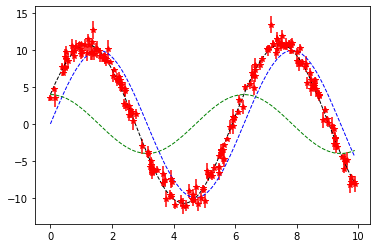

In [28]:
mu_l=[10.0,4.0,3.5]
dt_l=[0.0,1.57,0.5]
NI=2; 
fx=np.zeros((NI,len(x)))
for i in np.arange(NI): 
    fx[i]=intrinsic_func(x,mu_l[i],dt_l[i])
    
fx_total=np.sum(fx,axis=0)

y=np.random.normal(fx_total, sigfx)

plt.errorbar(x,y,yerr=sigfx,fmt='r*')
plt.plot(x,fx_total,c='k',lw=1.0,ls="--")
clr=["b","g","c"]
for i in range(NI):
    plt.plot(x,fx[i],c=clr[i],lw=1.0,ls="--")

plt.show()

In [33]:
#with lmfit minimization
p = lmfit.Parameters()

p.add_many(('mu1', 1.0),('mu2', 1.0),('dt1', 1.0),)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)+v['mu2']*np.sin(x+v['dt1']) - y)/sigfx

print(p)
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
print(mi)
#p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

#res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=200,
#                     params=mi.params, is_weighted=False)
#lmfit.report_fit(res.params)

Parameters([('mu1', <Parameter 'mu1', 1.0, bounds=[-inf:inf]>), ('mu2', <Parameter 'mu2', 1.0, bounds=[-inf:inf]>), ('dt1', <Parameter 'dt1', 1.0, bounds=[-inf:inf]>)])
[[Variables]]
    mu1:  14.0000582 +/-        nan (nan%) (init = 1)
    mu2:  5.52928675 +/-        nan (nan%) (init = 1)
    dt1:  2.34727169 +/-        nan (nan%) (init = 1)


In [47]:
#with lmfit emcee
%reset_selective -f mi
p = lmfit.Parameters()

p.add_many(('mu1', 8.0, True, 1.0,20.0),('mu2', 4.0,True, 1.0,10.0))
p.add('dt1', value=1.50, min=-1.0, max=1)
print(p)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)+v['mu2']*np.sin(x+v['dt1']) - y)/sigfx

print(p)
#mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
#lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
#print(mi)
p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=50,
                     params=p, is_weighted=False)
lmfit.report_fit(res.params)

  2%|▎         | 25/1000 [00:00<00:04, 243.68it/s]

Parameters([('mu1', <Parameter 'mu1', 8.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 4.0, bounds=[1.0:10.0]>), ('dt1', <Parameter 'dt1', 1, bounds=[-1.0:1]>)])
Parameters([('mu1', <Parameter 'mu1', 8.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 4.0, bounds=[1.0:10.0]>), ('dt1', <Parameter 'dt1', 1, bounds=[-1.0:1]>)])


100%|██████████| 1000/1000 [00:04<00:00, 230.63it/s]

[[Variables]]
    mu1:        4.79953293 +/- 1.92038292 (40.01%) (init = 8)
    mu2:        6.62327638 +/- 1.55126683 (23.42%) (init = 4)
    dt1:        0.63729082 +/- 0.16893877 (26.51%) (init = 1)
    __lnsigma:  0.07820053 +/- 0.05112464 (65.38%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, mu2) = -0.998
    C(mu1, dt1) =  0.980
    C(mu2, dt1) = -0.967


In [29]:
#using mcmc

def log_likelihood(theta, x, y, yerr): 
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    dp=len(x);
    fxx=np.zeros((NI,dp))
    for i in np.arange(NI):
        fxx[i]=mu[i]*np.sin(x+dt[i])#/np.power(x,pr)
        
    model =np.sum(fxx,axis=0) #mu*np.sin(x)/np.power(x,pr)
    sigma2 = yerr**2;#yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 /sigma2)

def log_prior(theta):
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    if 1.0 < mu[0] < 50.0 and 1.0 < mu[1] < 20.0 and -2 < dt1 <2:# and 0.0 < pr < 2.0:# and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

p0=np.array([1.0,1.5,0.0]);
Npar=len(p0); Nwalker=200
pos = p0 + 1e-4 * np.random.randn(Nwalker, Npar)
nwalkers, ndim = (Nwalker, Npar)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sigfx))
xxx1=sampler.run_mcmc(pos,2000);

In [30]:
flat_samples = sampler.get_chain(discard=200, thin=7, flat=True)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [2.5,16,25, 50,75, 84,97.5])
    print(mcmc)

[ 1.26039948  2.67652667  3.5047237   5.56523888  7.90990118  9.07390786
 11.17715452]
[3.92876312 4.14535541 4.52699318 6.02818541 7.70858248 8.43260179
 9.69811398]
[0.4191309  0.48709267 0.53722939 0.7134918  1.05815282 1.31139549
 1.83203529]


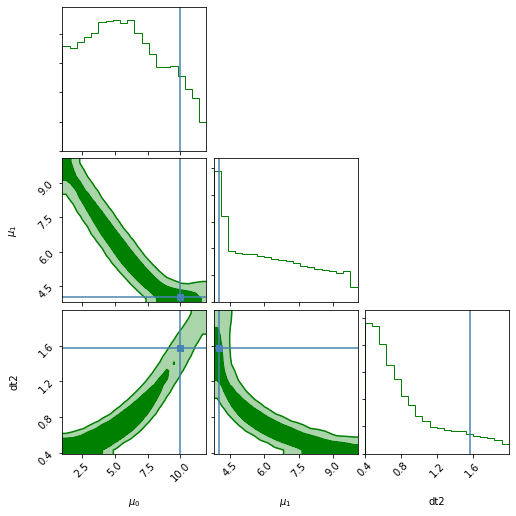

In [31]:
import corner
samples1 = sampler.chain[:, 300:, ].reshape((-1, 3))
fig1 = corner.corner(samples1, labels=[r"$\mu_0$",r"$\mu_1$","dt2"],
                        color='g', smooth=1,
                        levels=(0.68,0.95), plot_density=0, fill_contours=1, plot_datapoints=0, truths=[mu_l[0],mu_l[1], dt_l[1]])

In [32]:
model = """
data {
    int<lower=0> N;
    int<lower=0> np;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [np];
    real <lower=-2, upper=2> dt[np-1];
    //real sig;
    
}
model {
    real dum;
    real ddtt;
    for(i in 1:N) {
        dum=0;
        for (j in 1:np){
            ddtt=dt[1];
            if(j==1){ddtt=0;}
            dum=dum+mu[j]*sin(x[i]+ddtt);
        }
        //y[i] ~ normal((mu*sin(x[i])/pow(x[i],pr)), yerror[i]);
        y[i] ~ normal(dum, yerror[i]);
    }
}
"""
# Put our data in a dictionary
data = {'N': len(x),'np':NI, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1df7c204825e6d8256ad02c8d2941719 NOW.


Inference for Stan model: anon_model_1df7c204825e6d8256ad02c8d2941719.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   7.25    0.13   3.01   1.45   4.78   7.54   9.83  11.71    543    1.0
mu[2]   5.48    0.07   1.69   3.91    4.1   4.71   6.66   9.54    570    1.0
dt[1]   1.08    0.02   0.48   0.43   0.64   0.99   1.49   1.95    529    1.0
lp__  -113.5    0.04   1.33 -116.8 -114.2 -113.2 -112.6 -112.0    965    1.0

Samples were drawn using NUTS at Sun Nov 17 18:58:19 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [57]:
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [ni];
    real <lower=-2, upper=2> dt[ni-1];
    vector <lower=-1, upper=1> [NP] P;
    //real sig;
    
}
model {
    real dum;
    vector[NP] tm;
    real td=0.5;
    real dum_t;
    int ti;
    real dtt;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum_t=x[i];
        dum=0;
        for (j in 1:ni){
            dtt=dt[1];
            if(j==0){dtt=0;}
            dum_t=dum_t+dtt;
            while(dum_t<ti*td){
                ti=ti+1;
            }
            mod_intr_f=P[ti]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td);
            dum+=mu[i]*mod_intr_f;
        }
        y[i] ~ normal(dum, yerror[i]);
        
    }
}
"""
NP=21;
# Put our data in a dictionary
data = {'N': len(x),'ni':NI,'NP':NP, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc395dc4741f856c7acd84e7ca4b132c NOW.


RuntimeError: Exception: []: accessing element out of range. index -2147483648 out of range; expecting index to be between 1 and 21; index position = 1P  (in 'unknown file name' at line 37)


In [48]:
fit

Inference for Stan model: anon_model_1df7c204825e6d8256ad02c8d2941719.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   7.25    0.13   3.01   1.45   4.78   7.54   9.83  11.71    543    1.0
mu[2]   5.48    0.07   1.69   3.91    4.1   4.71   6.66   9.54    570    1.0
dt[1]   1.08    0.02   0.48   0.43   0.64   0.99   1.49   1.95    529    1.0
lp__  -113.5    0.04   1.33 -116.8 -114.2 -113.2 -112.6 -112.0    965    1.0

Samples were drawn using NUTS at Sun Nov 17 18:58:19 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [60]:
model = """
data {
    int<lower=0> N;
    int<lower=0> np;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real mu;
    //real dt[np];
    real pr;
    //real sig;
    
}
model {
    real dum;
    
    for(i in 1:N) {
        //dum=0;
        //for (j in 1:np){
        //      dum=dum+mu[j]*sin(x[i])/pow(x[i],pr);
        //}
        y[i] ~ normal((mu*sin(x[i])/pow(x[i],pr)), yerror[i]);
    }
}
"""
# Put our data in a dictionary
data = {'N': len(x),'np':NI, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4629e6fadf08db8d7cce4d4996d9fc05 NOW.


Inference for Stan model: anon_model_4629e6fadf08db8d7cce4d4996d9fc05.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    96.39   36.49  62.32    2.2  16.93 141.96 142.02 142.11      3   3.41
pr     0.11     0.3   0.61  -1.22  -0.59    0.5    0.5    0.5      4   1.93
lp__ -1.0e6   7.9e5  1.5e6 -4.2e6 -2.5e6 -57.21 -56.04 -55.56      3   2.77

Samples were drawn using NUTS at Thu Nov 14 23:57:26 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
tt=np.array([1,2,4,6])
if all(i < 4)

In [59]:
np.concatenate((mu_l,dt_l))

array([10. ,  4. ,  3.5,  0. ,  1.5,  0.5])